# Robotics: Assessment 2


## Summary & Introduction

The project aimed to train a robot to navigate to a goal without hitting obstacles using reinforcement learning models. Convergence was achieved with the True SARSA algorithm for linear function approximation, following some experimentation with different algorithms and hyperparameter tuning. However, VM limitations hindered training of the non-linear model to observe convergence. Despite this, the policy gradient method was explored, inheriting and expanding provided MRP and MDP classes and drawing inspiration from the provided DQN algorithm to develop a policy gradient method.

In [ ]:
%matplotlib inline

In [ ]:
import rclpy as ros
import time
from rclpy.node import Node

from geometry_msgs.msg import Twist
from nav_msgs.msg  import Odometry
from sensor_msgs.msg import LaserScan
from std_srvs.srv import Empty
from gazebo_msgs.srv import SpawnModel

import numpy as np
from numpy import Inf
from random import randint
from math import atan2, atan, pi
import matplotlib.pyplot as plt
ros.init()

## Creating Env Class

The provided environment class framework has been refined in my implementation. With adjustments to the reward function increasing the significance of goal achievement while still penalising the agent for hitting obstacles. Furthermore, optimisation measures, such as reducing laser scan dimensions from 60 to 30, have been implemented to speed up the training process. State representation is encoded using tile coding facilitated by index hash tables, using function published by Rich Sutton (http://incompleteideas.net/tiles/tiles3.py-remove). This implementation takes laser scan ranges as input and produces a tile coding matching input dimensions for compatibility. Larger tile coding vectors were causing errors when implementing training algorithms.

In [ ]:
def name(): return 'node'+str(randint(1,1000))

In [ ]:
basehash = hash

class IHT:
    # To handle collisions
    def __init__(self, sizeval):
        self.size = sizeval
        self.overfullCount = 0
        self.dictionary = {}

    def __str__(self):
        return "Collision table:" + \
               " size:" + str(self.size) + \
               " overfullCount:" + str(self.overfullCount) + \
               " dictionary:" + str(len(self.dictionary)) + " items"

    def count (self):
        return len(self.dictionary)

    def fullp (self):
        return len(self.dictionary) >= self.size

    def getindex (self, obj, readonly=False):
        d = self.dictionary
        if obj in d: return d[obj]
        elif readonly: return None
        size = self.size
        count = self.count()
        if count >= size:
            if self.overfullCount==0: print('IHT full, starting to allow collisions')
            self.overfullCount += 1
            return basehash(obj) % self.size
        else:
            d[obj] = count
            return count

def hashcoords(coordinates, m, readonly=False):
    if type(m)==IHT: return m.getindex(tuple(coordinates), readonly)
    if type(m)==int: return basehash(tuple(coordinates)) % m
    if m==None: return coordinates

from math import floor, log
from itertools import zip_longest

def tiles (ihtORsize, numtilings, floats, ints=[], readonly=False):
    # returns num-tilings tile indices corresponding to the floats and ints
    qfloats = [floor(f*numtilings) for f in floats]
    Tiles = []
    for tiling in range(numtilings):
        tilingX2 = tiling*2
        coords = [tiling]
        b = tiling
        for q in qfloats:
            coords.append( (q + b) // numtilings )
            b += tilingX2
        coords.extend(ints)
        Tiles.append(hashcoords(coords, ihtORsize, readonly))
    return Tiles

In [ ]:
class Env(Node):

# initialisation--------------------------------------------------------------
    # frequency: how many often (in seconds) the spin_once is invoked, or the publisher is publishing to the /cmd_vel
    def __init__(self, name=name(),
                 freq=1/25, n=20,
                 speed=.6, θspeed=pi/2,
                 rewards=[50, -10, 0, -1],
                 nF = 30,
                 verbose=False):
        super().__init__(name)

        self.freq = freq
        self.n = n
        self.nF = nF

        self.speed = speed
        self.θspeed = round(θspeed,2)

        self.robot = Twist()
        self.rewards = rewards
        self.verbose = verbose

        # do not change----------------------------------------------------
        self.x = 0 # initial x position
        self.y = 0 # initial y position
        self.θ = 0 # initial θ angle
        self.scans = np.zeros(30) # change to how many beams you are using
        self.t = 0

        self.tol = .6  # meter from goal as per the requirement (tolerance)
        self.goals =  [[2.0, 2.0], [-2.0, -2.0]]
        # -----------------------------------------------------------------

        self.controller = self.create_publisher(Twist, '/cmd_vel', 0)
        self.timer = self.create_timer(self.freq, self.control)

        self.scanner = self.create_subscription( LaserScan, '/scan', self.scan, 0)
        self.odometr = self.create_subscription( Odometry, '/odom', self.odom, 0)

        self.range_max = 3.5
        self.range_min = .3
        self.θresol = round(2*pi/12, 2)   # dividing a turning circle into sectors

        # establish a reset client
        self.reset_world = self.create_client(Empty, '/reset_world')
        while not self.reset_world.wait_for_service(timeout_sec=2.0):
            print('world client service...')


        # compatibility----------------------------------------------
        resol = .3
        θresol = 2*pi/8
        dims = [4,4]
        self.xdim = dims[0]  # realted to the size of the environment
        self.ydim = dims[1]  # realted to the size of the environment

        self.resol = round(resol,2)
        self.θresol = round(θresol,2)

        self.cols  = int(self.xdim//self.resol) +1   # number of grid columns, related to linear speed
        self.rows  = int(self.ydim//self.resol) +1   # number of grid rows,    related to linear speed
        self.orts  = int(2*pi//self.θresol)     +1   # number of angles,       related to angular speed

        self.nC = self.rows*self.cols              # Grid size
        self.nS = self.rows*self.cols*self.orts # State space size
        self.nA = 3


        self.Vstar = None # for compatibility
        # ---------------------------------------------------------------
        # self.rate = self.create_rate(30)
        self.reset()

        print('speed  = ', self.speed)
        print('θspeed = ', self.θspeed)
        print('freq   = ', self.freq)

# sensing--------------------------------------------------------------
    # odometry (position and orientation) readings
    def odom(self, odoms):
        self.x = round(odoms.pose.pose.position.x, 1)
        self.y = round(odoms.pose.pose.position.y, 1)
        self.θ = round(self.yaw(odoms.pose.pose.orientation),2)
        self.odom = np.array([self.x, self.y, self.θ])
        if self.verbose: print('odom = ',  self.odom )

    # laser scanners readings
    def scan(self, scans):
        self.scans = np.array(scans.ranges)
        self.scans[scans==Inf] = self.range_max
        if self.verbose: print('scan = ', self.scans.round(2))

    # converting to the quaternion self.z to Euler
    # see https://www.allaboutcircuits.com/technical-articles/dont-get-lost-in-deep-space-understanding-quaternions/#
    # see https://eater.net/quaternions/video/intro

    def yaw(self, orient):
        x, y, z, w = orient.x, orient.y, orient.z, orient.w
        yaw = atan2(2.0*(x*y + w*z), w*w + x*x - y*y - z*z)
        return yaw if yaw>0 else yaw + 2*pi # in radians, [0, 2pi]

    # angular distance of robot to a goal.............................................
    def θgoal(self, goal):
        xgoal, ygoal = self.goals[goal]
        x, y  = self.x, self.y
        θgoal = atan2(abs(xgoal-x), abs(ygoal-y)) # anglegoal
        # if θgoal<=0  θgoal += 2*pi
        return round(θgoal, 2) # in radians, [0, 2pi]

    # Eucleadian distance of robot to nearest goal......................................
    def distgoal(self):
        dists = [Inf, Inf]        # distances of robot to the two goals
        for goal, (xgoal, ygoal) in enumerate(self.goals):
            dists[goal] = (self.x - xgoal)**2 + (self.y - ygoal)**2

        dist = min(dists)         # nearest goal distance
        goal = dists.index(dist)  # nearest goal index

        if self.verbose: print('seeking goal ____________________', goal)
        return round(dist**.5, 2), goal

    # robot reached goal ...............................................................
    def atgoal(self):
        tol, x, y = self.tol,  self.x, self.y
        atgoal = False
        for xgoal, ygoal in self.goals:
            atgoal = xgoal + tol > x > xgoal - tol  and  \
                     ygoal + tol > y > ygoal - tol

            if atgoal: print('Goal has been reached woohoooooooooooooooooooooooooooooo!!'); break
        return atgoal

    # robot hits a wall...................................................................
    def atwall(self, rng=4):
        # check only 2*rng front scans for collision
        return np.r_[self.scans[-rng:], self.scans[:rng]].min() < self.range_min

    # reward function to produce a suitable policy..........................................
    def reward(self, a, imp=2):
        stype = [self.atgoal(), self.atwall(), a==1, a!=1].index(True)

        dist, goal = self.distgoal()
        θgoal = self.θgoal(goal)

        # get angular distance to reward/penalise robot relative to its orientation towards a goal
        θdist = abs(self.θ - θgoal)
        if goal==1: θdist -= pi
        θdist = round(abs(θdist),2)

        reward = self.rewards[stype]
        if stype: reward -= imp*(dist+θdist)

        if self.verbose:
            print('reward components=',
                  'Total reward=', reward,
                  'state reward=', self.rewards[stype],
                  'goal dist=', dist,
                  '|θ-θgoal|=', θdist)

        # reset without restarting an episode if the robot hits a wall
        if stype==1: self.reset()

        return reward, stype==0, stype==1

# State representation-------------------------------------------------
   # Hash table method to create tile index using laser scan ranges (tile coding)
    def s_(self):
        nF, scans, range_max = self.nF, self.scans, self.range_max
        φ = np.r_[scans[-nF//2:], scans[:nF//2]]
        φ[φ==Inf] = range_max
        φ_norm = φ/φ.sum()
        tile_indices = np.array(tiles(1024, 30, φ_norm))
        return tile_indices/tile_indices.sum()

# Control--------------------------------------------------------------
    def spin_n(self, n):
        for _ in range(n): ros.spin_once(self)

    def control(self):
        self.controller.publish(self.robot)

    # move then stop to get a defined action
    def step(self, a=1, speed=None, θspeed=None):
        if speed is None: speed = self.speed
        if θspeed is None: θspeed = self.θspeed

        self.t +=1
        if self.verbose: print('step = ', self.t)

        if  a==-1: self.robot.linear.x  = -speed  # backwards
        elif a==1: self.robot.linear.x  =  speed  # forwards
        elif a==0: self.robot.angular.z =  θspeed # turn left
        elif a==2: self.robot.angular.z = -θspeed # turn right

        # Now move and stop so that we can have a well defined actions
        self.spin_n(self.n) if a==1 else self.spin_n(self.n//2)
        self.stop()

        reward, done, wall = self.reward(a)
        return self.s_(), reward, done, {}

    def stop(self):
        self.robot.linear.x = .0
        self.robot.angular.z = .0
        self.spin_n(self.n//8)

    def reset(self):
        print('Resetting world..........................................')

        # Stop any ongoing actions (for example, stop movement)
        self.stop()  # Define a method to stop the robot's actions

        # Reset the world
        for _ in range(2): self.reset_world.call_async(Empty.Request())
        for _ in range(2): self.step(a=1, speed=0.0001)
        for _ in range(1): self.reset_world.call_async(Empty.Request())

        return self.s_()


    # for compatibility, no need to change
    def render(self, **kw):
        pass

Initialising the assessment environment now it is connected to the notebook.

<code>ros2 launch turtlebot3_gazebo turtlebot3_assessment2.launch.py</code>

In [ ]:
from RL import *
from RLv import *

In [ ]:
venv = Env(speed= .75, θspeed=pi*0.75, verbose=False)

Resetting world..........................................
speed  =  0.75
θspeed =  2.36
freq   =  0.04


## Action-Value Function with Linear Function Approximation

Initially, several algorithms were considered to assess overall performance and and test default parameters before selecting the most suitable model. Among the three variations of SARSA (SARSA, Expected SARSA and True SARSA), the True SARSA model yielded the best initial results.

### Sarsa

Starting with the vectorised SARSA algorithm with the default parameters and short episode lengths. Initially, I set the reward function to assign a large positive reward for reaching the goal position and a significant penalty for colliding with an obstacle.

However, this initial model did not produce notable results, since the agent consistently reached the maximum time steps without navigating to the goal. Extending the training for a further 150 episodes revealed no learning progress, as it continued to exhibit the same behaviour. As a result, the next algorithm evaluated was Expected SARSA.

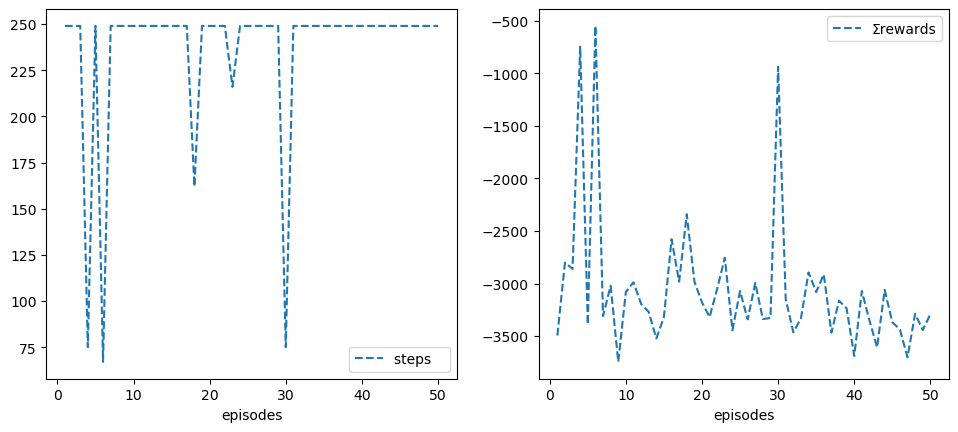

In [ ]:
# rewards=[75,-100,0,-1]
vsarsa = Sarsaλ(env=venv, α=.1, max_t=250, episodes=50, seed=1, **demoGame()).interact()
# 92 mins/ 1 hr 32 mins

CPU times: user 6min 48s, sys: 55.2 s, total: 7min 43s
Wall time: 3h 3min 14s


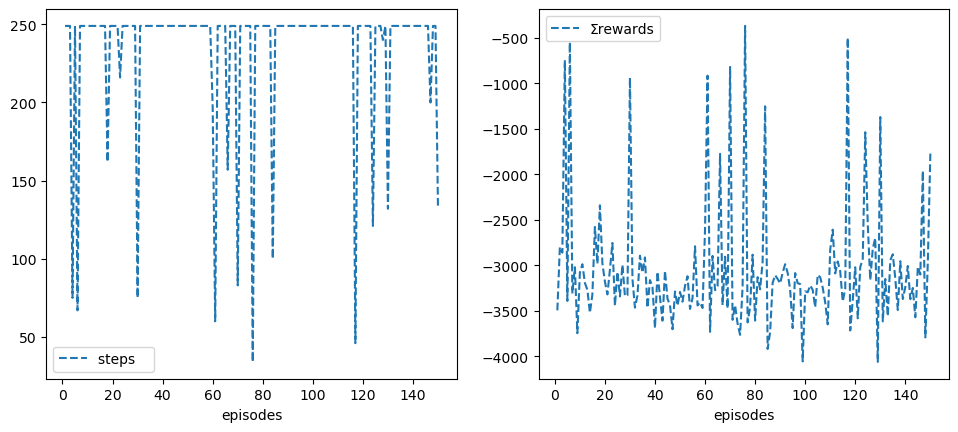

In [ ]:
vsarsa.episodes = 150
%time vsarsa.interact(resume=True)

CPU times: user 3min 25s, sys: 27.2 s, total: 3min 52s
Wall time: 1h 31min 7s


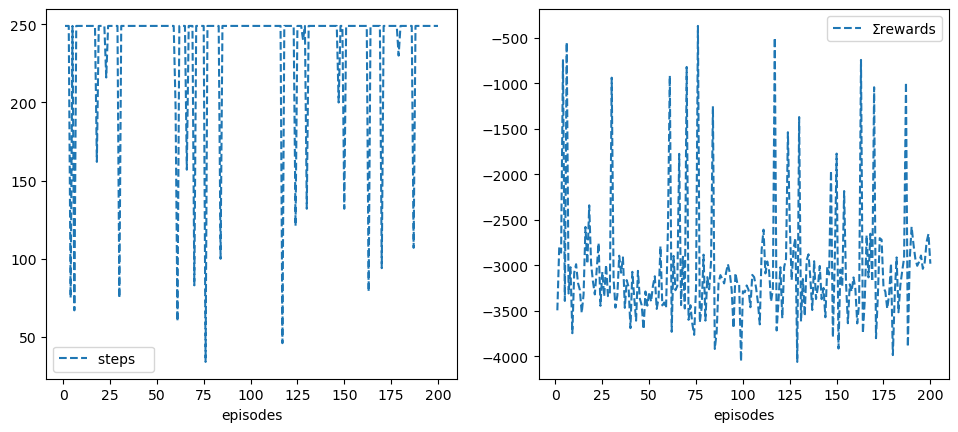

In [ ]:
vsarsa.episodes = 200
%time vsarsa.interact(resume=True)

### Expected Sarsa

Testing the expected SARSA algorithm with a smaller step size parameter and no discounting yielded similar unsatisfactory results, with the same maximum time step limit and reward function. Again in this case the agent reached the time step limit before navigating to the goal position, resulting in limited learning.

Upon testing the vectorised Expected SARSA algorithm with a smaller step size parameter with no discounting, outcomes mirrored those of the SARSA evaluation. The reward function and maximum time steps remained unchanged. Despite these adjustments, the agent encountered the same limitations; consistently reaching the maximum time step limit without reaching the goal position. Consequently, learning remained limited.

CPU times: user 11min 5s, sys: 25.2 s, total: 11min 30s
Wall time: 5h 54min 13s


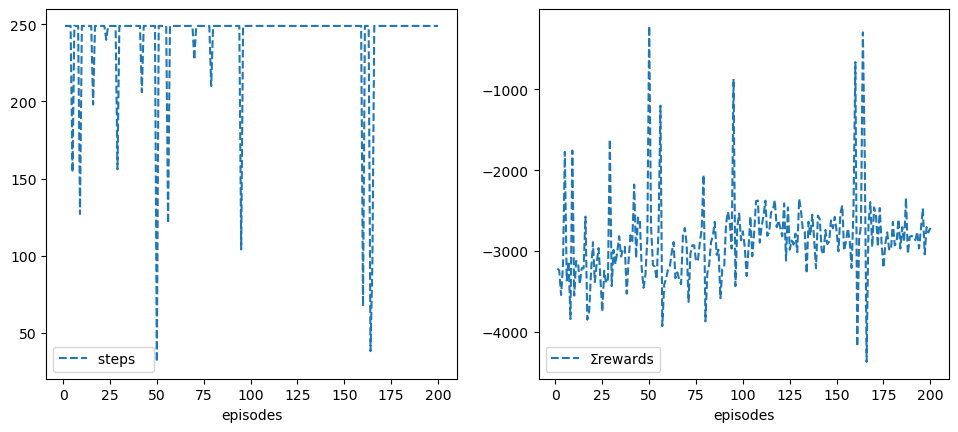

In [ ]:
%time xsarsa = XSarsa(env=venv, α=.5, γ=1, max_t=250, episodes=200, seed=2, **demoGame()).interact()

### True Sarsa

The next model under evaluation was True SARSA, with an eligibility trace parameter, λ, set relatively high at 0.9, assigning higher significance to recent episodes. However, results from 100 training episodes exhibited the same limitation observed in previous tests. This suggests the need to increase the maximum time step to allow the agent to explore the environment sufficiently.

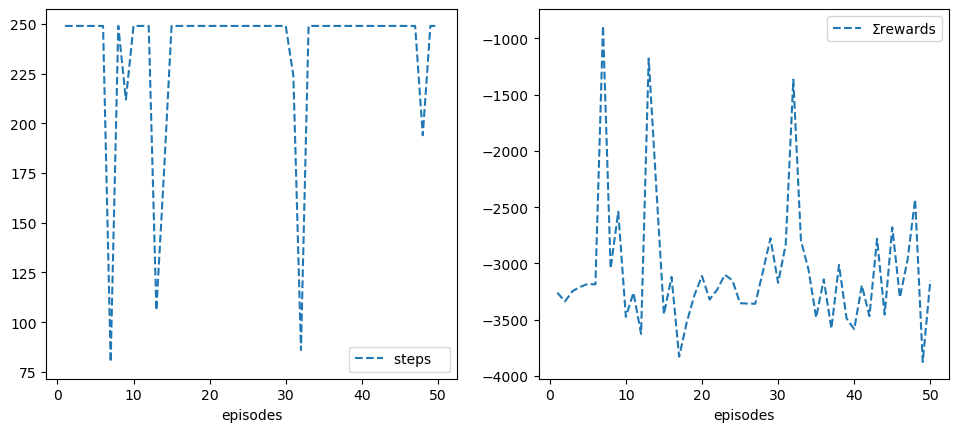

In [ ]:
truesarsaλ = trueSarsaλ(env=venv, λ=.9, episodes=50, max_t = 250, seed=3, **demoGame()).interact()
# 92.24 mins/ 1 hr 32 mins

CPU times: user 2min 44s, sys: 6.13 s, total: 2min 50s
Wall time: 1h 26min 59s


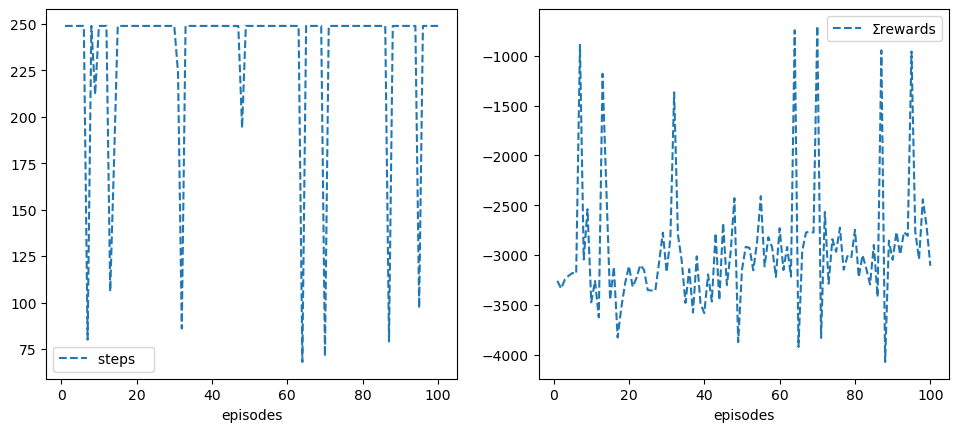

In [ ]:
truesarsaλ.episodes = 100
%time truesarsaλ.interact(resume=True)

#### With exponential decay of epsilon

##### Model 1

In the following iteration, the maximum time steps were extended to 500 to facilitate more comprehensive learning, resulting in a significant increase in training time. Additionally, adjustments were made to the reward function, reducing the reward for navigating to the goal and minimising penalties for colliding with obstacles.

The exploration parameter, ε, was set to 0.5 for the initial 75 episodes, followed by a gradual reduction of 10% in each subsequent episode until reaching a minimum value or the end of episodes.

The model demonstrates signs of convergence towards the end of the first 150 episodes, with the agent requiring fewer steps to reach the goal and incurring fewer penalties over time. However, extending the training to a total of 500 episodes revealed a plateau in performance, suggesting a limitation in further improvement. Notably, there was some variability in results, with the agent exhibiting occasional deviations from optimal performance in certain episodes after convergence.

The prolonged training time for this algorithm can be attributed to the increased maximum time steps, the fixed exploration parameter for the initial episodes, and the slow decay of ε thereafter.

Moving forward, the plan is to explore variation in parameters, including reducing the total number of episodes and adjusting the timing of ε decay to further optimise the model's performance.

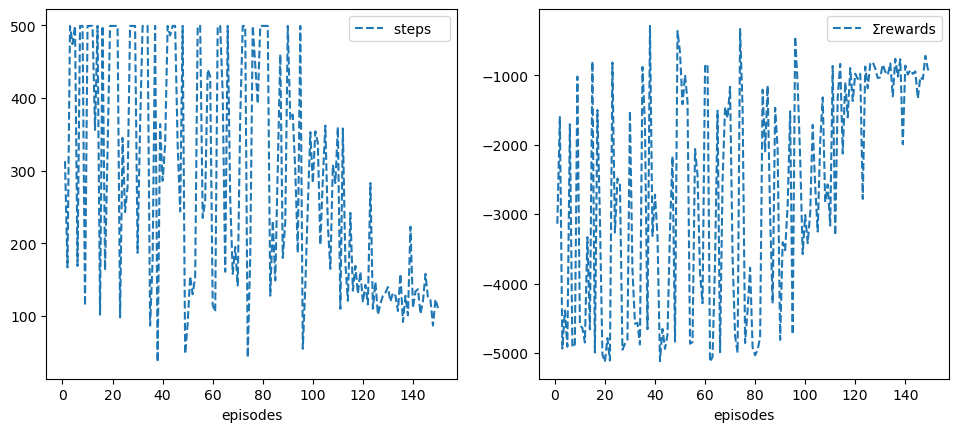

In [ ]:
#rewards=[50,-10,0,-1]
truesarsaλ2 = trueSarsaλ(env=venv, λ=.5, episodes=150, max_t=500, ε=.5, dε=.9, εT=75, seed=4, **demoGame()).interact()
# 408.2 mins

CPU times: user 7min 15s, sys: 17 s, total: 7min 32s
Wall time: 4h 1min 58s


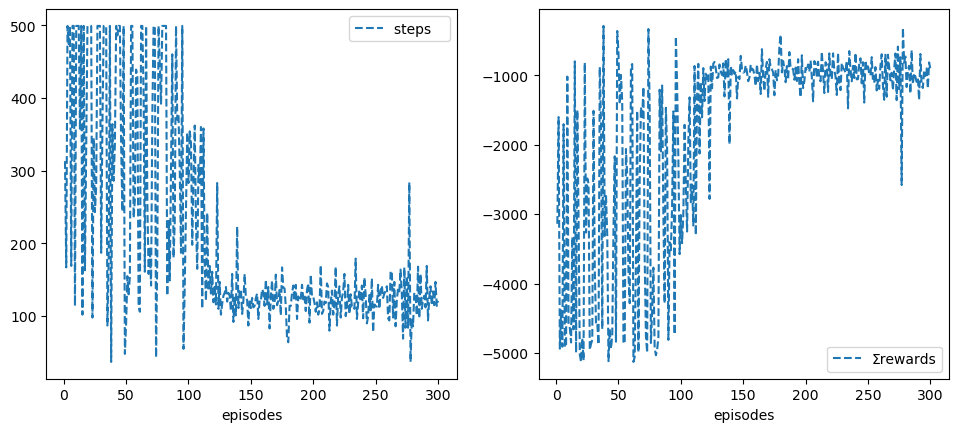

In [ ]:
truesarsaλ2.episodes = 300
%time truesarsaλ2.interact(resume=True)

CPU times: user 10min 5s, sys: 24.9 s, total: 10min 30s
Wall time: 5h 31min 57s


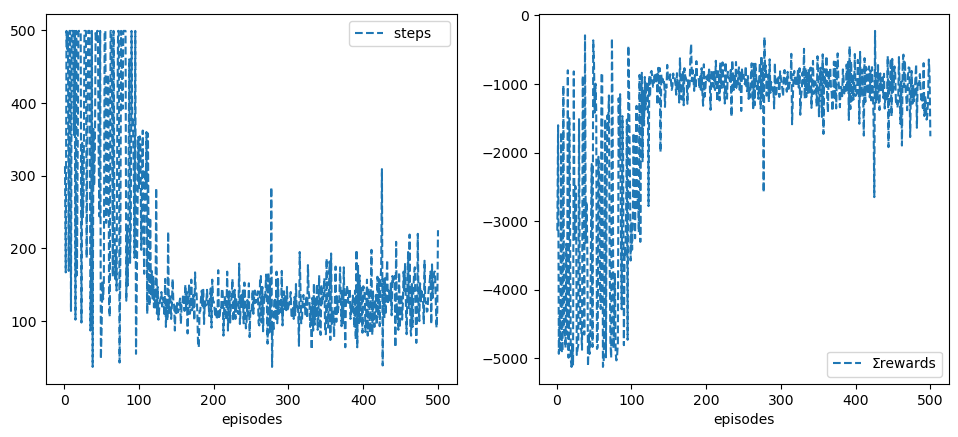

In [ ]:
truesarsaλ2.episodes = 500
%time truesarsaλ2.interact(resume=True)

##### Model 2

With the goal of expediting convergence, the total number of episodes was reduced to 100 in the following implementation, while maintaining a maximum time step limit of 500 to control training duration. The subsequent plots reveal that in most episodes, the time step limit was reached before the agent navigated to the goal, resulting in substantial penalties in the reward function.

To enhance exploration, the number of episodes with high exploration was decreased to 50, allowing the agent ample opportunity to explore the environment before exploiting its acquired knowledge. The plots depict the model gradually converging towards the end of training. Extending training by 15 episodes yielded high variability, as previously observed, in the number of steps taken until termination.

This suggests that convergence is hindered by the slow decay of ε, impeding the model's ability to exploit its knowledge effectively. The following model will explore variations in the exploration, ε, the rate of its decay and the starting point of decay to address this issue.

CPU times: user 8min 43s, sys: 22.3 s, total: 9min 5s
Wall time: 4h 48min 8s


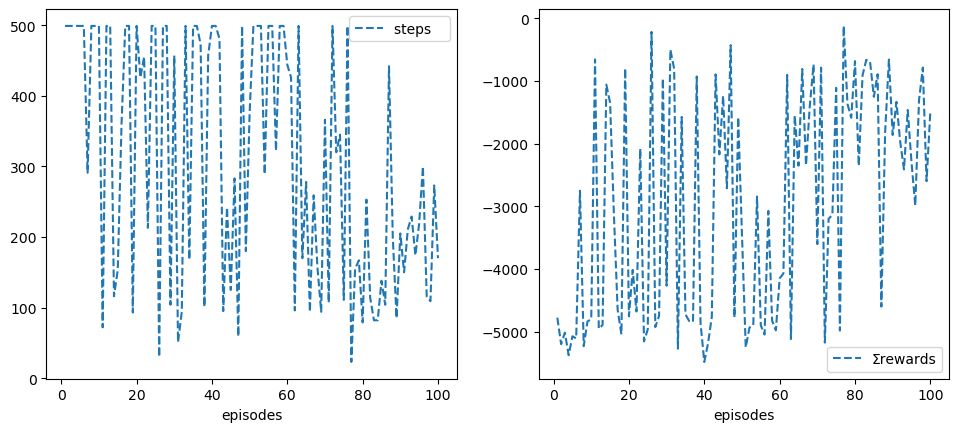

In [ ]:
%time truesarsaλ3 = trueSarsaλ(env=venv, λ=.5, episodes=100, max_t=500, ε=.5, dε=.9, εT=50, seed=5, **demoGame()).interact()

CPU times: user 1min 2s, sys: 2.71 s, total: 1min 5s
Wall time: 35min 26s


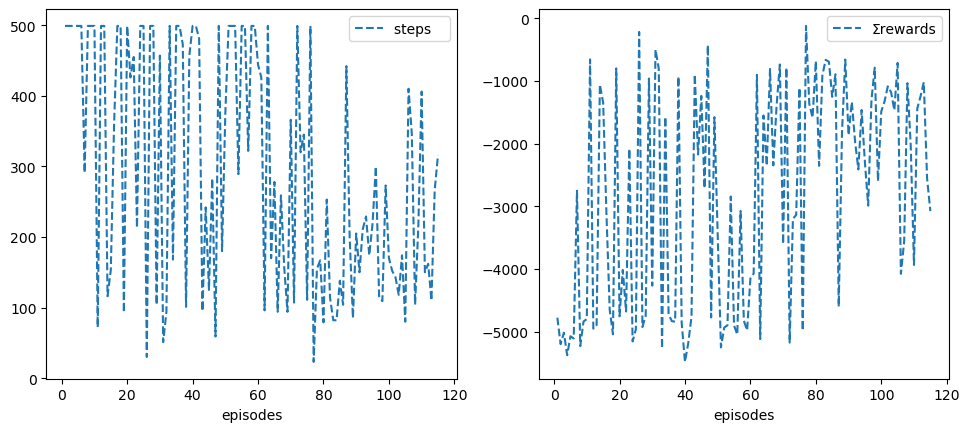

In [ ]:
truesarsaλ3.episodes = 115
%time truesarsaλ3.interact(resume=True)

##### Model 3

To address the issue of the agent consistently hitting the time step limit before reaching the goal, maximum time steps was increased to 800. However, as anticipated, this adjustment prolonged the total training duration slightly.

In this model, the exploration parameter, ε, was set relatively high at 0.7 with a 30% decay in each episode following the initial 20. This deliberate choice was aimed to ensure thorough exploration of the environment by the agent, allowing it to gather sufficient knowledge for later exploitation. Additionally, the total number of episodes was reduced to expedite training.

The ensuing plots demonstrate a marked improvement, both in terms of steps taken to reach the goal and the reward function, particularly evident in the final 10 episodes. To verify whether this improvement reflected genuine convergence rather than chance, training was extended by 35 episodes. The subsequent plots revealed the model's convergence after a total of 110 episodes, with only one episode exhibiting a significantly higher number of steps taken before reaching the goal after convergence.

CPU times: user 9min 52s, sys: 24.9 s, total: 10min 17s
Wall time: 5h 41min 55s


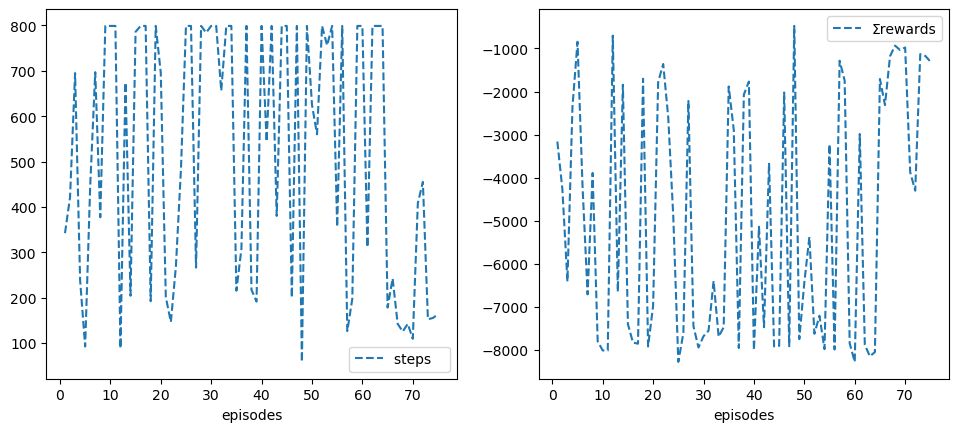

In [ ]:
%time truesarsaλ4 = trueSarsaλ(env=venv, λ=.5, episodes=75, max_t=800, ε=.7, dε=.7, εT=20, seed=6, **demoGame()).interact()

CPU times: user 1min 29s, sys: 3.91 s, total: 1min 33s
Wall time: 48min 10s


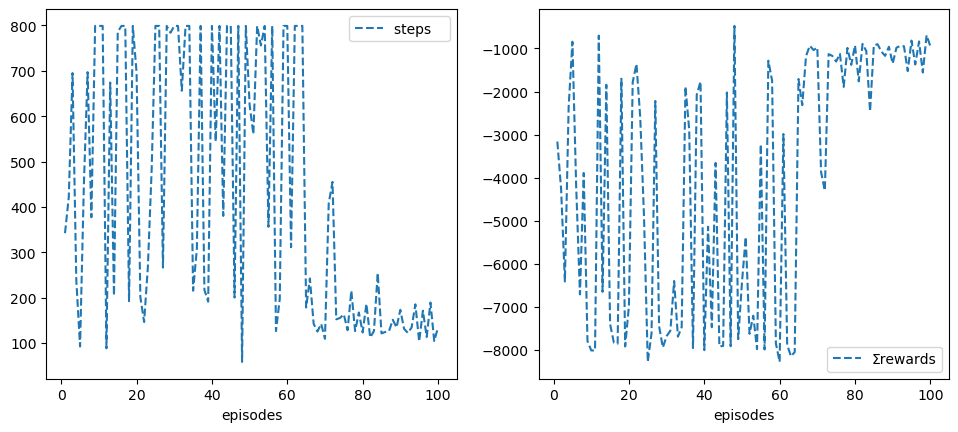

In [ ]:
truesarsaλ4.episodes = 100
%time truesarsaλ4.interact(resume=True)

CPU times: user 39.2 s, sys: 1.81 s, total: 41 s
Wall time: 21min 3s


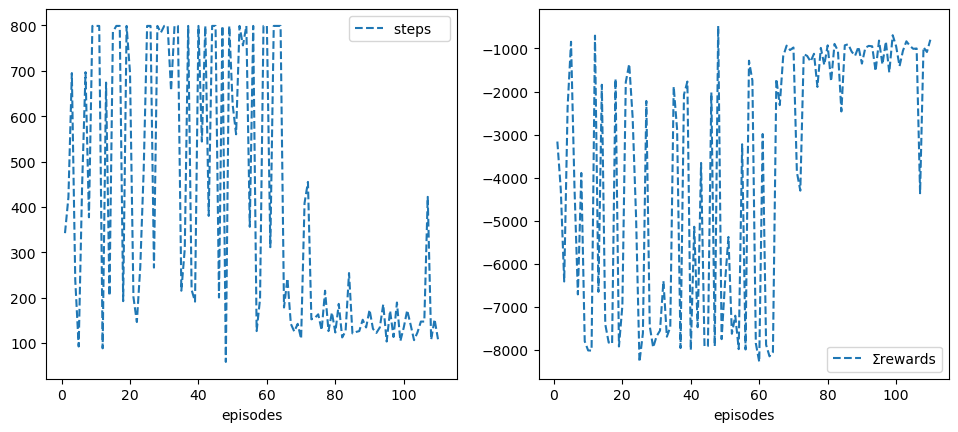

In [ ]:
truesarsaλ4.episodes = 110
%time truesarsaλ4.interact(resume=True)

## Policy Gradient with Non-Linear Function Approximation

The next task involves developing a policy gradient model with non-linear function approximation. While the lessons provided the code for non-linear models, it focussed on function approximation techniques for value function models. Building upon this existing code, I've inherited and extended it to devise a policy gradient method.

In [ ]:
from RL import *

import time
import os
import cv2
import numpy as np

import matplotlib.pyplot as plt
from numpy.random import rand
from collections import deque
from itertools import islice
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation

import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

from IPython.display import clear_output

from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

2024-05-06 13:55:50.502373: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 13:55:51.421649: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-06 13:55:51.431699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 13:55:53.991402: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


To reduce the complexity of the model and prevent the VM from crashing during training, I've opted to adjust the state representation by reducing its dimensionality from 30 to 15. This reduction in complexity should help enhance the model's stability and performance during training.

In [ ]:
class vEnv(Env):
    def __init__(self, nscans=30, **kw):
        self.nF = 15
        self.nscans = nscans
        super().__init__(**kw)

    def s_(self):
        nF, scans, range_max, nscans = self.nF, self.scans, self.range_max, self.nscans
        φ = np.r_[scans[-nscans//2:], scans[:nscans//2]]
        φ = np.concatenate((scans[-nF::2], scans[:nF:2]))
        φ[φ==Inf] = range_max
        φ_norm = φ/φ.sum()
        tile_indices = np.array(tiles(512, 15, φ_norm))

        return tile_indices/tile_indices.sum()

In [ ]:
venv = vEnv(speed= .75, θspeed=pi*0.75, verbose=False)

[WARN] [1715003765.245351943] [rcl.logging_rosout]: Publisher already registered for provided node name. If this is due to multiple nodes with the same name then all logs for that logger name will go out over the existing publisher. As soon as any node with that name is destructed it will unregister the publisher, preventing any further logs for that name from being published on the rosout topic.


Resetting world..........................................
speed  =  0.75
θspeed =  2.36
freq   =  0.04



Below is the modified MRP class from the lessons, where the number of features has been reduced to enhance the stability of the model further.

In [ ]:
class MRP(MRP):
    def __init__(self, γ=0.99, nF=64, nbuffer=1000, nbatch=32, rndbatch=True,
                 save_weights=1000,     # save weights every now and then
                 load_weights=False,
                 print_=True,
                 **kw):

        super().__init__(γ=γ, **kw)
        self.nF = nF   # feature extraction is integrated within the neural network model not the env

        self.nbuffer  = nbuffer
        self.nbatch   = nbatch
        self.rndbatch = rndbatch

        self.load_weights_= load_weights
        self.save_weights_= save_weights # used to save the target net every now and then

        self.update_msg = 'update %s network weights...........! %d'
        self.saving_msg = 'saving %s network weights to disk...! %d'
        self.loading_msg = 'loading %s network weights from disk...!'

    def init(self):
        self.vN = self.create_model('V')                      # create V deep network
        if self.load_weights_: self.load_weights(self.vN,'V') # from earlier training proces
        self.V = self.V_

    #-------------------------------------------Deep model related---------------------------
    def create_model(self, net_str):
        x0 = Input(self.env.reset().shape)#(84,84,1))#self.env.frame_size_)
        x = Conv2D(32, 8, 4, activation='relu')(x0)
        x = Conv2D(64, 4, 2, activation='relu')(x)
        x = Conv2D(64, 3, 1, activation='relu')(x)
        x = Flatten()(x)
        x = Dense(self.nF, 'relu')(x)
        x = Dense(1 if net_str=='V' else self.env.nA)(x)
        model = Model(x0, x)
        model.compile(Adam(self.α), loss='mse')
        model.summary() if net_str != 'Qn' else None
        model.net_str = net_str
        return model

    def load_weights(self, net, net_str ):
        print(self.loading_msg%net_str)
        loaded_weights = net.load_weights(net_str)
        loaded_weights.assert_consumed()

    def save_weights(self):
        print(self.saving_msg%('V',self.t_))
        self.vN.save_weights('V')

    #------------------------------------- value related -----------------------------------
    def V_(self, s, Vs=None):

        # update the V network if Vs is passed
        if Vs is not None: self.vN.fit(s, Vs, verbose=0); return None

        # predict for one state for εgreedy, or predict for a batch of states, copy to avoid auto-grad issues
        return self.vN.predict(np.expand_dims(s, 0))[0] if len(s.shape)!=4 else np.copy(self.vN.predict(s))

    #-------------------------------------------buffer related----------------------------------
    def allocate(self):
        self.buffer = deque(maxlen=self.nbuffer)

    def store_(self, s=None,a=None,rn=None,sn=None,an=None, done=None, t=0):
        self.save_weights() if self.save_weights_ and self.t_%self.save_weights_==0 else None
        self.buffer.append((s, a, rn, sn, done))

    # deque slicing, cannot use buffer[-nbatch:]
    def slice_(self, buffer, nbatch):
        return list(islice(buffer, len(buffer)-nbatch, len(buffer)))

    def batch(self):
        # if nbatch==nbuffer==1 then (this should give the usual qlearning without replay buffer)
        # sample nbatch tuples (each tuple has 5 items) without replacement or obtain latest nbatch from the buffer
        # zip the tuples into one tuple of 5 items and convert each item into a np array of size nbatch

        samples = sample(self.buffer, self.nbatch) if self.rndbatch else self.slice_(self.buffer, self.nbatch)
        samples = [np.array(experience) for experience in zip(*samples)]

        # generate a set of indices handy for filtering, to be used in online()
        inds = np.arange(self.nbatch)

        return samples, inds

The code below inherits from the provided MRP class, with a modification to the `create_model` method. It now consists of an input layer with 15 units, a hidden layer with ReLU activation and an output layer with softmax activation, representing the action probabilities for the policy (Actor). This modification aims to adapt the model to handle state representations with reduced dimensionality while maintaining the functionality for policy-based learning.

In [ ]:
from tensorflow.keras import layers, Model

class My_MRP(MRP):
    def __init__(self, num_hidden=128, num_actions=3, **kwargs):
        super().__init__(**kwargs)
        self.num_hidden = num_hidden
        self.num_actions = num_actions

    def create_model(self, net_str):
        inputs = layers.Input(shape=(15))
        common = layers.Dense(self.num_hidden, activation="relu")(inputs)
        action = layers.Dense(self.num_actions, activation="softmax")(common) # Actor
        x = Flatten()(action)
        x = Dense(self.nF, 'relu')(x)
        x = Dense(1 if net_str=='p' else self.env.nA)(x)

        model = Model(inputs=inputs, outputs=action)
        model.compile(optimizer=Adam(self.α), loss='categorical_crossentropy')
        model.summary()
        model.net_str = net_str
        return model

The `PolicyGradMDP` class inherits from the edited MRP class`My_MRP` and is designed for a policy gradient algorithm. The policy networks are initialised, allows weights to be saved and loaded from previous training sessions to handle VM crashes. The `p_` method is responsible for predicting the policy for a given state or batch of states. It uses the policy network, `pN`, to predict action probabilities based on the current state. The `pNN` method updates the target policy network, which is essential to stabilise training in policy gradient methods.

In [ ]:
class PolicyGradMDP(My_MRP):
    def __init__(self, create_pN=True, **kwargs):
        super().__init__(**kwargs)
        self.create_pN = create_pN

    def init(self):
        super().init() if self.create_pN else None
        self.pN = self.create_model('p')  # Create main policy network
        self.pNN = self.create_model('pNN')  # Create target network to estimate p(sn)

        self.load_weights(self.pN, 'p') if self.load_weights_ else None  # Load weights from earlier training for policy network
        self.load_weights(self.pNN, 'p') if self.load_weights_ else None  # Load weights from earlier training for target policy network

        self.p = self.p_

    def save_weights(self):
        super().save_weights() if self.create_pN else None  # Save weights of policy network if create_pNN is True
        print(self.saving_msg % ('p ', self.t_))
        self.pN.save_weights('p')

    def set_weights(self, net):
        print(self.update_msg % (net.net_str, self.t_))
        net.set_weights(self.pN.get_weights())

    #------------------------------------------------ Policy Related -----------------------------------
    def p_(self, s, ps=None):
        # Update the policy networks if ps is passed
        if ps is not None:
            self.pNN.fit(s, ps, verbose=0)
            return None

        # Predict the policy for one state or a batch of states
        return self.pN.predict(np.expand_dims(s, 0))[0] if len(s.shape) != 2 else np.copy(self.pN.predict(s))


    def pNN(self, sn, update=False):
        # Update the target policy network if update is True
        if update:
            self.set_weights(self.pNN)
            return None

        # Predict the policy for a given state sn
        return self.pNN.predict(sn)

The `PolicyGrad` class is designed to implement the policy gradient method. Inheriting from the `PolicyGradMDP` class, it updates the online policy network based on experiences collected in a buffer. By sampling batches of experiences, it adjusts the probabilities of actions using a policy gradient update rule, incorporating rewards and estimated values from a target policy network. This process aims to improve the policy's performance over time by iteratively adjusting action probabilities to maximize rewards. Additionally, it periodically updates the target policy network to stabilize training. Overall, the class facilitates the learning process by iteratively improving the policy's decision-making capabilities through online learning and target network updates.

In [ ]:
class PolicyGrad(PolicyGradMDP):
    def __init__(self, α=1e-4, t_pNN=1000, **kwargs):
        print('--------------------- Policy Gradient DQN is being set up -----------------------')
        super().__init__(**kwargs)
        self.α = α
        self.store = True
        self.t_pNN = t_pNN

    # ------------------------------- Online Learning ---------------------------------
    # Update the online policy network in every step using a batch
    def online(self, *args):
        # No updates unless the buffer has enough samples
        if len(self.buffer) < self.nbuffer: return

        # Sample a tuple batch: each component is a batch of items
        (s, a, rn, sn, dones), inds = self.batch()

        # Obtain the policy-values estimation from the two networks
        ps = self.p(s)
        pNN = self.pNN(sn)

        terminal_mask = tf.cast(dones, dtype=tf.float32)
        pNN = pNN * (1 - terminal_mask[:, tf.newaxis])

        # policy gradient update rule
        ps[inds, a] = self.γ * tf.reduce_max(pNN, axis=1) + rn

        self.p(s, ps)
        self.pNN(sn, self.t_ % self.t_pNN == 0)

The first model tested retained most parameters at their default values. The maximum time steps were increased to 1000, and both buffer and batch size were set to 32. Additionally, the `t_pNN` parameter was adjusted to 1000, signifying updates to the policy network every 1000 time steps. Initially, the number of episodes was set to 75 to evaluate the policy gradient algorithm's performance.

However, training halted abruptly after only 13 episodes due to the VM freezing. To stabilize the model, I adjusted some hyperparameters and re-ran the model. Initial results replicate the patterns observed in the initial models for the linear case, with much variability in the reward function as well as the time taken to reach the goal, although we cannot draw definitive conclusions from these results.

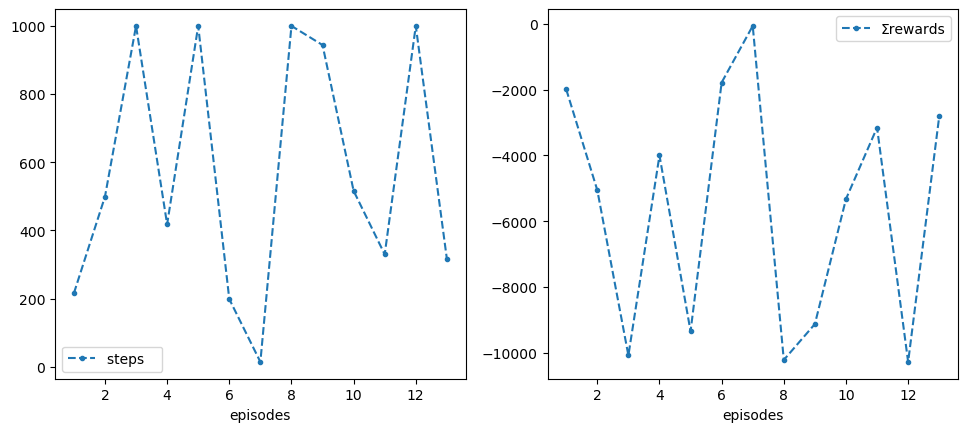

Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 24ms/step
Resetting world..........................................
1/1 [==============================] - 0s 16ms/step
Resetting world..........................................
1/1 [==============================] - 0s 23ms/step
Resetting 

2024-05-05 14:37:29.489369: W tensorflow/core/data/root_dataset.cc:286] Optimization loop failed: CANCELLED: Operation was cancelled


1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 20ms/step
Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 25ms/step
Resetting world..........................................
1/1 [==============================] - 0s 24ms/step
Resetting world..........................................
1/1 [==============================] - 0s 18ms/step
Resetting world..........................................
1/1 [==============================] - 0s 28ms/step
Resetting world..........................................
1/1 [==============================] - 0s 22ms/step
Resetting world..........................................
1/1 [=====

In [ ]:
%time pg = PolicyGrad(env=venv, seed=500, episodes=75, max_t=1000, rndbatch=False, t_pNN=1000, nbuffer=32, nbatch=32, **demoGame()).interact()

In this implementation, adjustments were made to several parameters to enhance training stability. Specifically, the batch size and buffer size were reduced to 16, while the maximum time steps were decreased to 800 and the policy network was set to update after each episode. Additionally, the step-size parameter α was tuned to 0.9, and the discount factor γ was set to 0.9 to moderate the influence of future rewards, promoting more consistent learning. I also employed the `save_weights` hyperparameter to save model weights at the end of each episode to allow training to continue in case the VM crashed.

Despite these modifications, the issue with VM crashing persisted. To address this, incremental training was adopted, increasing the episode count by 10 in each iteration. However, extending the training episodes to a total of 20 still resulted in the VM crashing after the 13th episode. Again, we cannot make any meaningful inferences from the progress plots.

CPU times: user 11min 18s, sys: 23.6 s, total: 11min 41s
Wall time: 48min 34s


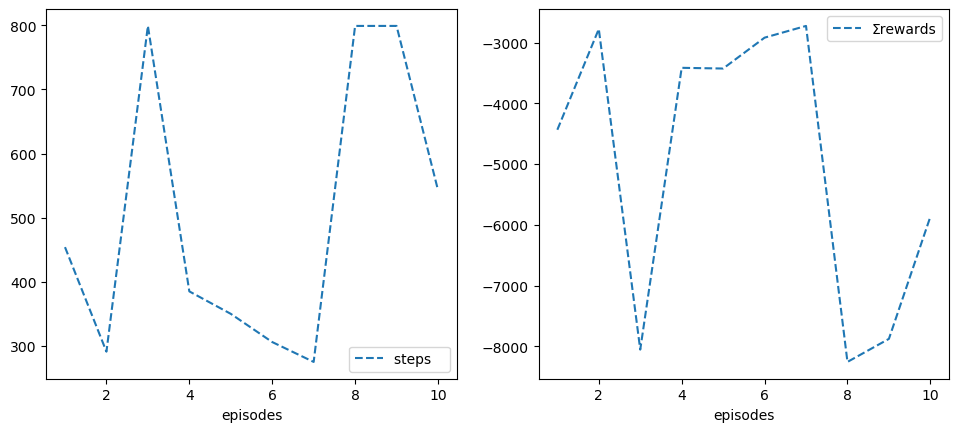

In [ ]:
%time pg1 = PolicyGrad(env=venv, seed=501, α=.9, γ=.9, episodes=10, max_t=800, rndbatch=False, t_pNN=800, nbuffer=16, nbatch=16, save_weights=800 **demoGame()).interact()

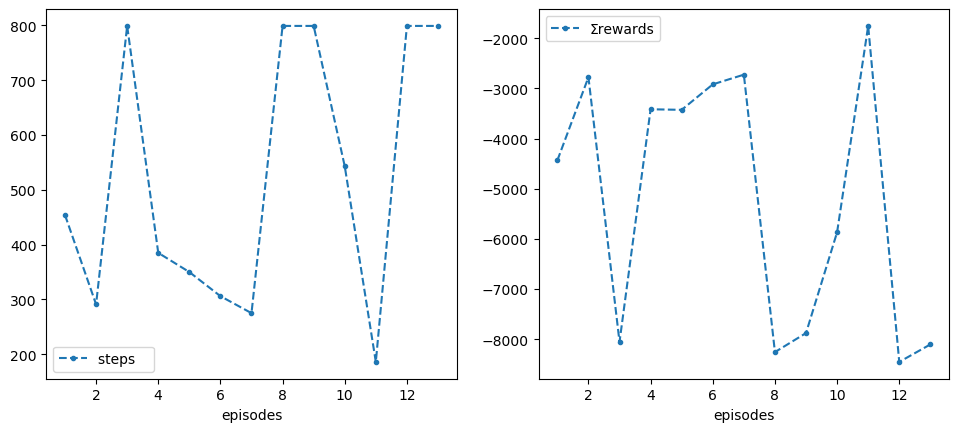

Resetting world..........................................
1/1 [==============================] - 0s 23ms/step
Resetting world..........................................
1/1 [==============================] - 0s 23ms/step
Resetting world..........................................
1/1 [==============================] - 0s 20ms/step
Resetting world..........................................
1/1 [==============================] - 0s 18ms/step
Resetting world..........................................
1/1 [==============================] - 0s 25ms/step
Resetting world..........................................
1/1 [==============================] - 0s 20ms/step
saving p  network weights to disk...! 7000
1/1 [==============================] - 5s 5s/step


In [ ]:
pg1.episodes = 20
%time dqn1.interact(resume=True)

In the model below I utilised the `load_weights` functionality provided in the MRP class to load the previously saved weights and resume training. Unfortunately, the VM crashed again, this time following the 11th episode.

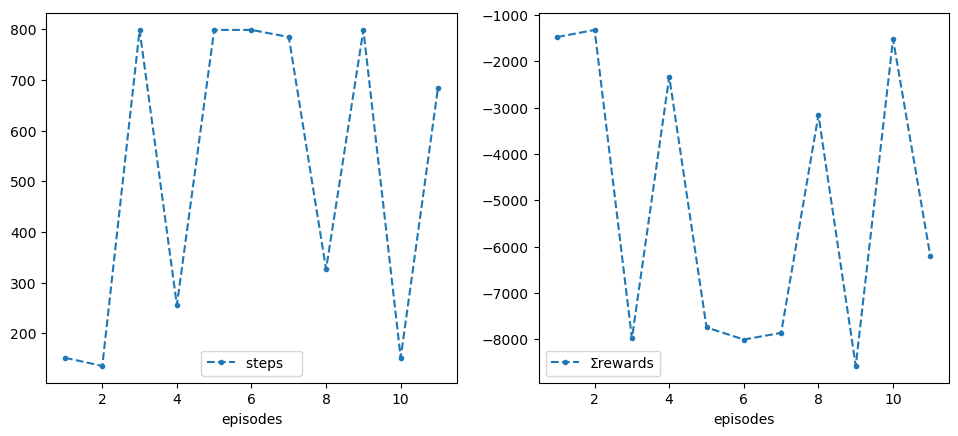

Resetting world..........................................
1/1 [==============================] - 0s 20ms/step
Resetting world..........................................
1/1 [==============================] - 0s 26ms/step
Resetting world..........................................
1/1 [==============================] - 0s 24ms/step
Resetting world..........................................
1/1 [==============================] - 0s 28ms/step
Resetting world..........................................
1/1 [==============================] - 0s 22ms/step
Resetting world..........................................
1/1 [==============================] - 0s 29ms/step
Resetting world..........................................
1/1 [==============================] - 0s 30ms/step
Resetting world..........................................
1/1 [==============================] - 0s 24ms/step
Resetting world..........................................
1/1 [==============================] - 0s 20ms/step
Resetting 

In [ ]:
%time pg2 = PolicyGrad(env=venv, seed=502, α=.9, γ=.9, episodes=20, max_t=800, rndbatch=False, t_pNN=800, nbuffer=16, nbatch=16, save_weights=800, load_weights = True, **demoGame()).interact()

In an attempt to simplify the neural network architecture and potentially improve training stability, the number of hidden layers in the model was reduced to 64. However, despite this adjustment, with all other parameters remained unchanged, this model iteration did not yield significant improvements or address the challenges encountered during training.

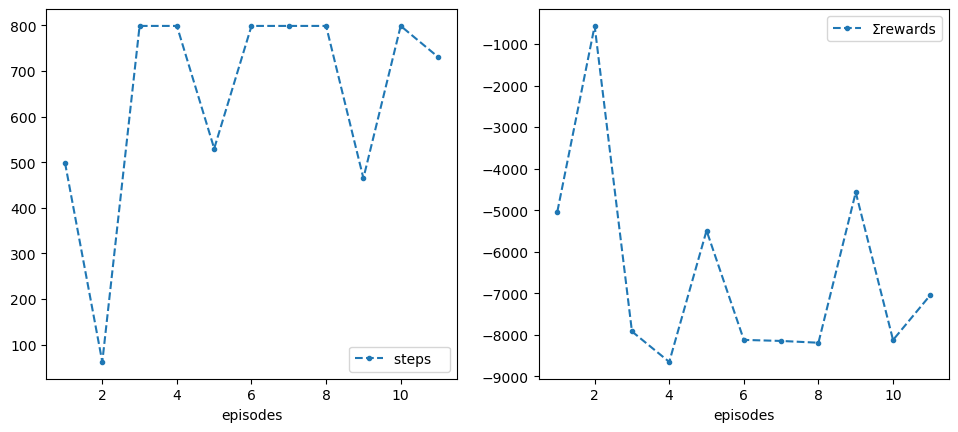

Resetting world..........................................
1/1 [==============================] - 0s 24ms/step
Resetting world..........................................
1/1 [==============================] - 0s 34ms/step
Resetting world..........................................
1/1 [==============================] - 0s 22ms/step
Resetting world..........................................
1/1 [==============================] - 0s 22ms/step
saving p  network weights to disk...! 7200
1/1 [==============================] - 0s 26ms/step
Resetting world..........................................
1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 18ms/step
Resetting world..........................................
1/1 [==============================] - 0s 20ms/step
Resetting world..........

In [ ]:
%time pg3 = PolicyGrad(env=venv, seed=503, num_hidden=64, α=.9, γ=.9, episodes=20, max_t=800, rndbatch=False, t_pNN=800, nbuffer=16, nbatch=16, save_weights=800, **demoGame()).interact()

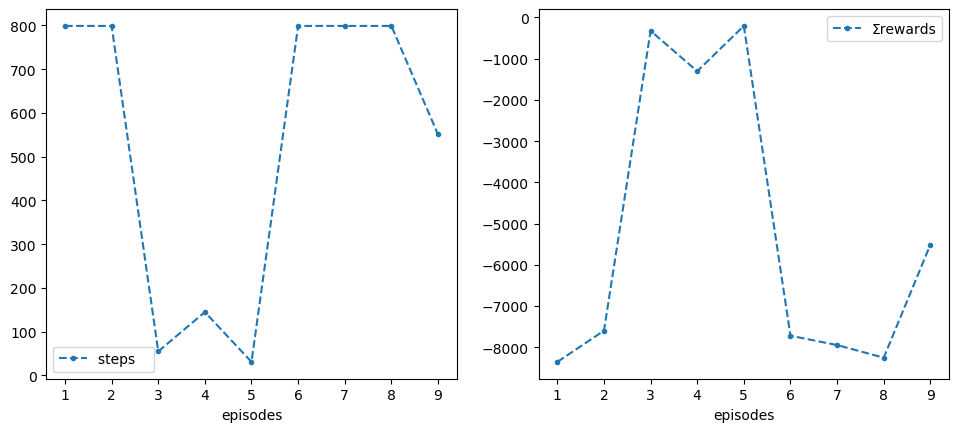

Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 98ms/step
Resetting world..........................................
1/1 [==============================] - 0s 36ms/step
saving p  network weights to disk...! 4800
1/1 [==============================] - 0s 21ms/step
Resetting world..........................................
1/1 [==============================] - 0s 22ms/step
Resetting world..........................................
1/1 [==============================] - 0s 19ms/step
Resetting world..........................................
1/1 [==============================] - 0s 16ms/step


In [ ]:
%time pg4 = PolicyGrad(env=venv, seed=504, num_hidden=64, α=.9, γ=.9, episodes=20, max_t=800, rndbatch=False, t_pNN=800, nbuffer=16, nbatch=16, save_weights=800, load_weights=True, **demoGame()).interact()

Overall, my attempts to train the policy gradient model with non-linear function approximation were unsuccessful due to recurrent issues with the VM crashing after only a few episodes. Despite multiple adjustments to hyperparameters and the neural network architecture, I was unable to overcome these challenges and achieve stable training.

## Conclusion and Reflection


In conclusion, this project explored various reinforcement learning models to train a robot to navigate to a goal while avoiding obstacles. Experimentation with linear models resulted in convergence achieved with the True SARSA algorithm after tuning epsilon and its decay rate. Despite this success, attempts to train a non-linear model were hindered by limitations of the virtual machine (VM), leading to crashes after only a few episodes. Efforts to mitigate this included adjusting hyperparameters and simplifying the neural network architecture. However, stable training of the non-linear model remained unattainable. While convergence was observed in linear models, the inability to adequately train the non-linear model due to VM limitations highlights a significant challenge in scaling reinforcement learning algorithms. Future work could focus on using GPU's to overcome these limitations and facilitate the successful training of non-linear models.